In [1]:
import sys
!{sys.executable} -m pip install autograd 

In [2]:
import autograd.numpy as np
import numpy as numpy
from autograd import grad, elementwise_grad
from sklearn.linear_model import LinearRegression, Lasso
import matplotlib.pylab as plt
import pandas as pd

In [4]:
###Utility Functions###
def generate_perturbed_X(X, delta, sampling, S, seed=0):
    np.random.seed(seed=seed)
    N = X.shape[0]
    D = X.shape[1]

    X_expanded = X[np.newaxis, :, :]
    if sampling == 'normal':
         epsilon_s = np.random.normal(0 , delta, size=(S, N, D))
         X_perturbed =  X_expanded + epsilon_s
    elif sampling == 'logitnormal':

        epsilon = 1e-6
        X_clipped = np.clip(X_expanded, epsilon, 1 - epsilon)
        # Apply the logit function to get log-odds
        X_logit = logit(X_clipped)

        # Correct noise shape here, broadcast compatible with `X_logit`
        noise_shape = (S, N, D)
        noise = np.random.normal(0, delta, size=noise_shape)

        # Add Gaussian noise to the log-odds
        noisy_X_logit = X_logit + noise

        # Convert back to probabilities and round the result if needed
        X_perturbed = expit(noisy_X_logit)
    else:
        raise  Exception('Sampling {} not defined,'.format('sampling'))

    return X_perturbed

In [5]:
def similarity(X_perturbed, X_original, sigma=2):
    '''
    kernel_fn: computes the similarity between perturbed inputs and the original input
    input:
        X_perturbed(S, D): S perturbed versions of the input, each with D features
        X_original(D): the original input
        sigma: bandwidth for the Gaussian kernel
    output:
        pi_x(S): array of similarity scores for each perturbed sample
    '''
    distance = np.linalg.norm(X_perturbed - X_original, axis=1)
    pi_x = np.exp(-distance ** 2 / (sigma ** 2))

    return pi_x

In [6]:
def compute_LIME_explanations(X, X_perturbed, fn, y_sample):
    """
    Compute a matrix of explanations for each sample.
    Parameters:
        X (np.array): Original dataset of shape (N, D).
        X_perturbed (np.array): Perturbed inputs of shape (S, N, D).
        fn (function): Model to explain.
        y_sample (np.array): Target classes for each sample in X.
    Returns:
        np.array: Explanations matrix of shape (N, D).
    """
    S, N, D = X_perturbed.shape
    Explanations = np.zeros((N, D))
    linear_model = LinearRegression()  # Instantiate the regression model once
    # lasso_model = Lasso(alpha=0.001, max_iter=1000)

    for i in range(N):
        print(i)
        perturbed_sample_i = X_perturbed[:, i, :]
        target = fn(perturbed_sample_i)
        # Extract the revelant score for the corresponding class
        target_class = target[:, y_sample[i]]

        # Compute coefficients for the current sample
        pi_x = similarity(perturbed_sample_i, X[i])
        linear_model.fit(perturbed_sample_i, target_class, sample_weight=pi_x)

        # lasso_model.fit(perturbed_sample_i, target_class, sample_weight=pi_x) 
        # coef = lasso_model.coef_
        
        coef = linear_model.coef_
        Explanations[i, :] = np.abs(coef)  # Store absolute values of coefficients

    return Explanations


In [11]:
def LIME_global_mean(explanations, y_sample=None, class_of_interest=None):
    """
    Compute the mean explanation for all samples, or filter by class if specified.
    Parameters:
        explanations (np.array): Explanation matrix of shape (N, D).
        y_sample (np.array, optional): Array of true class labels of shape (N,). Required if filtering by class.
        class_of_interest (int, optional): The class for which to filter explanations.
    Returns:
        np.array: Mean explanation vector of shape (D,).
    """
    if class_of_interest is not None:
        if y_sample is None:
            raise ValueError("y_sample must be provided if class_of_interest is specified.")
        
        # Filter explanations for the class of interest
        target_indices = y_sample == class_of_interest
        filtered_explanations = explanations[target_indices, :]
        # Compute the mean explanation for the filtered data
        mean_explanation = np.mean(filtered_explanations, axis=0)
    else:
        # Compute the mean explanation for all samples
        mean_explanation = np.mean(exp, axis=0)
    
    return mean_explanation


In [13]:
def LIME_global_paper(explanations, y_sample=None, class_of_interest=None):
    """
    Aggregate the explanations matrix using the formula sqrt(sum(|W_ij|)) for each feature.
    If class_of_interest is specified, filters the explanations first.
    Parameters:
        explanations (np.array): Explanation matrix of shape (N, D).
        y_sample (np.array, optional): Array of true class labels of shape (N,).
        class_of_interest (int, optional): The class for which to filter explanations.
    Returns:
        np.array: Aggregated explanations of shape (D,).
    """
    if class_of_interest is not None:
        if y_sample is None:
            raise ValueError("y_sample must be provided if class_of_interest is specified.")
        # Filter explanations for the class of interest
        target_indices = y_sample == class_of_interest
        explanations = explanations[target_indices, :]
    
    # Compute the aggregation for each feature
    return np.sqrt(np.sum(np.abs(explanations), axis=0))


In [15]:
def LIME_global_normalization(explanations, y_sample=None, class_of_interest=None):
    """
    Compute global LIME explanations by aggregating over all samples with normalization.
    If class_of_interest is specified, filters the explanations first.
    Parameters:
        explanations (np.array): Explanation matrix of shape (N, D).
        y_sample (np.array, optional): Array of true class labels of shape (N,).
        class_of_interest (int, optional): The class for which to filter explanations.
    Returns:
        np.array: Normalized global explanations of shape (D,).
    """
    if class_of_interest is not None:
        if y_sample is None:
            raise ValueError("y_sample must be provided if class_of_interest is specified.")
        # Filter explanations for the class of interest
        target_indices = y_sample == class_of_interest
        explanations = explanations[target_indices, :]

    # Compute normalized global explanations
    non_zero = np.sum(explanations > 0, axis=0)
    non_zero_sum = np.sum(explanations, axis=0)
    Global = non_zero_sum / non_zero
    Global[np.isnan(Global)] = 0  # Handle division by zero

    return Global

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np
from scipy.special import expit, logit
import matplotlib.pyplot as plt

In [18]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshape data to add channel dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")

x_train shape: (60000, 28, 28, 1), x_test shape: (10000, 28, 28, 1)


In [77]:
# Generate a model
# model = models.Sequential([
#     layers.Input(shape=(28, 28, 1)),  # Explicit Input layer
#     layers.Conv2D(32, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(10, activation='softmax')
# ])

# model.summary()
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    # Block 1: Convolution + MaxPooling
    layers.Input(shape=(28, 28, 1)),  # Explicit Input layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Block 2: Convolution + MaxPooling
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # Output layer for classification
])

# Print the model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [81]:
model.fit(x_train, y_train, epochs=10, validation_split=0.1)

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7397 - loss: 0.7654 - val_accuracy: 0.9828 - val_loss: 0.0597
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9585 - loss: 0.1444 - val_accuracy: 0.9875 - val_loss: 0.0439
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9712 - loss: 0.1065 - val_accuracy: 0.9895 - val_loss: 0.0370
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9724 - loss: 0.1003 - val_accuracy: 0.9892 - val_loss: 0.0356
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9774 - loss: 0.0841 - val_accuracy: 0.9888 - val_loss: 0.0371
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9793 - loss: 0.0769 - val_accuracy: 0.9900 - val_loss: 0.0333
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9794 - loss: 0.0749 - val_accuracy: 0.9910 - val_loss: 0.0322
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.9829 - loss: 

In [83]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9890 - loss: 0.0335
Test accuracy: 0.9912999868392944


In [90]:
sampling = "normal"
S = 1000
delta = 0.25
num_points = 500

# Take a subset of test data to explain
indices = np.random.choice(x_test.shape[0], num_points, replace=False)
x_sample = x_test[indices]
y_sample = y_test[indices]

N = x_sample.shape[0]
X = x_sample.reshape(x_sample.shape[0], -1)
D = X.shape[1]
X_perturbed = generate_perturbed_X(X, delta, sampling, S)

In [92]:
fn = lambda x: model.predict(x.reshape(x.shape[0], 28, 28, 1))

In [94]:
explanations = compute_LIME_explanations(X, X_perturbed, fn, y_sample)

0
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
2
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
6
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
8
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
14
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
16
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
17
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
18
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
19
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
21
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
22
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
23
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
2

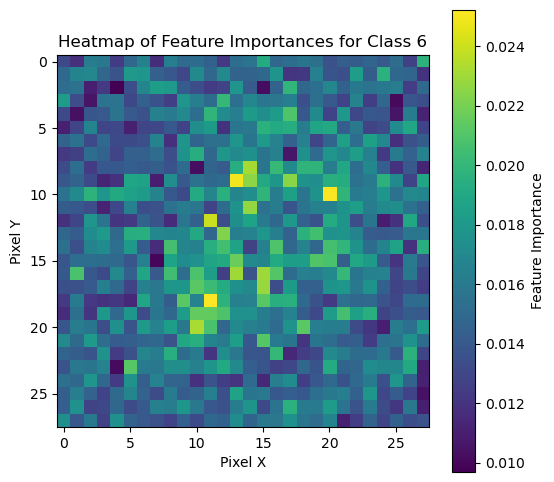

In [106]:
# Plot a simple average of all explanations for "class of interest" given that the actual digit is "class of interest"
class_of_interest = 6
mean_explanation = LIME_global_mean(explanations, y_sample = y_sample, class_of_interest = class_of_interest)

# Reshape to 28x28
heatmap_average = mean_explanation.reshape(28, 28)

# Plot the heatmap
plt.figure(figsize=(6, 6))
plt.imshow(heatmap_average, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Feature Importance')
plt.title(f'Heatmap of Feature Importances for Class {class_of_interest}')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

In [ ]:
# Plot a simple sqrt sum of all explanations for "class of interest" given that the actual digit is "class of interest"
sum_explanation = LIME_global_paper(explanations, y_sample = y_sample, class_of_interest = 6)

# Reshape to 28x28
heatmap_paper = sum_explanation.reshape(28, 28)

# Plot the heatmap
plt.figure(figsize=(6, 6))
plt.imshow(heatmap_paper, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Feature Importance')
plt.title(f'Heatmap of Feature Importances for Class {class_of_interest}')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

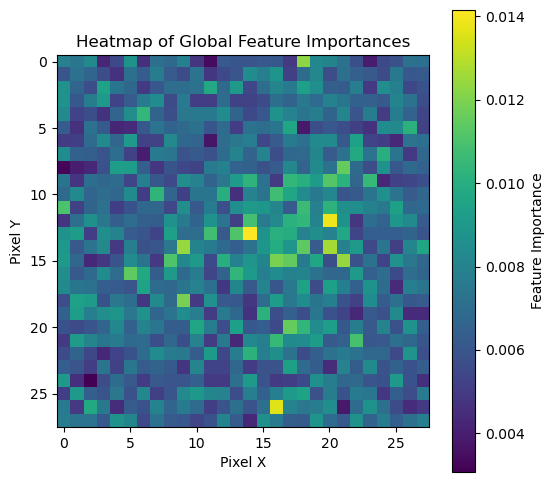

In [110]:
# Generate explanations
global_exp_norm = LIME_global_normalization(explanations, y_sample = y_sample, class_of_interest = 0)

# Reshape to 28x28
heatmap_norm = global_exp_norm.reshape(28, 28)

# Plot the heatmap
plt.figure(figsize=(6, 6))
plt.imshow(heatmap_norm, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Feature Importance')
plt.title('Heatmap of Global Feature Importances')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

In [112]:
def mask_top_pixels(data, top_n):
    """
    Mask all but the top_n most important pixels in the data.
    
    Parameters:
        data (np.array): 1D array of feature importances.
        top_n (int): Number of top pixels to retain.
        
    Returns:
        np.array: Masked 1D array with only the top_n pixels retained.
    """
    # Flatten the data to sort
    flat_data = data.flatten()
    # Find the threshold for the top_n largest values
    threshold = np.partition(flat_data, -top_n)[-top_n]
    # Create a mask for pixels above the threshold
    masked_data = np.where(flat_data >= threshold, flat_data, 0)
    return masked_data.reshape(data.shape)

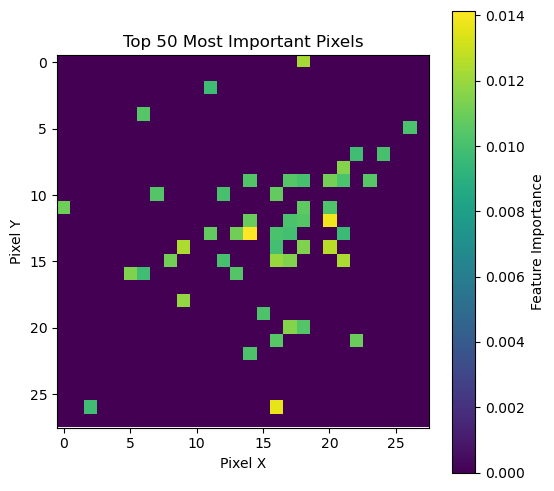

In [116]:
# Generate explanations
global_exp_norm = LIME_global_normalization(explanations, y_sample=y_sample, class_of_interest=0)

# Reshape to 28x28
heatmap_norm_masked = global_exp_norm.reshape(28, 28)

# Mask all but the top 50 most important pixels
heatmap_norm_masked = mask_top_pixels(heatmap_global, top_n=50)

# Plot the masked heatmap
plt.figure(figsize=(6, 6))
plt.imshow(heatmap_norm_masked, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Feature Importance')
plt.title('Top 50 Most Important Pixels')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()

In [130]:
import matplotlib.pyplot as plt

def save_and_plot_explanations(exp, y_sample, method='simple', output_prefix='explanations'):
    """
    Save explanations for each class using simple averaging or normalization
    and plot heatmaps for each explanation.
    
    Parameters:
        exp (np.array): Explanation matrix of shape (N, D).
        y_sample (np.array): Array of true class labels of shape (N,).
        method (str): Aggregation method, either 'simple', 'paper', or 'normalization'.
        output_prefix (str): Prefix for the output CSV and plot files.
    """
    for class_of_interest in range(10):  # Assuming 10 classes (0–9)
        if method == 'simple':
            mean_explanation = LIME_global_mean(exp, y_sample=y_sample, class_of_interest=class_of_interest)
        elif method == 'paper':
            mean_explanation = LIME_global_paper(exp, y_sample=y_sample, class_of_interest=class_of_interest)
        elif method == 'normalization':
            mean_explanation = LIME_global_normalization(exp, y_sample=y_sample, class_of_interest=class_of_interest)
        else:
            raise ValueError("Invalid method. Use 'simple', 'paper', or 'normalization'.")
        
        # Reshape the explanation to 28x28
        mean_explanation_reshaped = mean_explanation.reshape(28, 28)
        
        # Save to CSV
        df = pd.DataFrame(mean_explanation_reshaped)
        df.to_csv(f'{output_prefix}_class_{class_of_interest}.csv', index=False, header=True)
        
        # Plot the heatmap
        plt.figure(figsize=(6, 6))
        plt.imshow(mean_explanation_reshaped, cmap='viridis', interpolation='nearest')
        plt.colorbar(label='Feature Importance')
        plt.title(f'{method.capitalize()} Explanation for Class {class_of_interest}')
        plt.xlabel('Pixel X')
        plt.ylabel('Pixel Y')
        plt.savefig(f'{output_prefix}_class_{class_of_interest}.png')  # Save the plot
        plt.close()  # Close the plot to free memory

In [132]:
save_and_plot_explanations(explanations, y_sample, method='simple', output_prefix='simple_avg')
save_and_plot_explanations(explanations, y_sample, method='paper', output_prefix='paper')
save_and_plot_explanations(explanations, y_sample, method='normalization', output_prefix='normalized')

In [134]:
def build_pruning_graphs(x_train, y_train, x_test, y_test):
    """
    Build pruning graphs for all classes using saved explanation CSV files.
    
    Parameters:
        x_train (np.array): Training data of shape (N, H, W, C).
        y_train (np.array): Training labels.
        x_test (np.array): Test data of shape (M, H, W, C).
        y_test (np.array): Test labels.
    """
    methods = ['simple_avg', 'paper', 'normalized']
    pruning_ratios = np.linspace(0.1, 0.9, 9)  # Prune 10% to 90%
    results = {method: [] for method in methods}  # Store accuracies for each method

    for class_of_interest in range(10):
        plt.figure(figsize=(8, 6))
        for method in methods:
            # Load the explanation CSV for this class and method
            csv_path = f'{method}_class_{class_of_interest}.csv'
            importances = pd.read_csv(csv_path).to_numpy()
            
            # Flatten importances to match feature space
            importances_flat = importances.flatten()
            
            # Sort indices in ascending order of importance
            sorted_indices = np.argsort(importances_flat)
            
            accuracies = []
            X_copy = np.copy(x_train)
            
            # Perform pruning for each ratio
            for p in pruning_ratios:
                # Prune the least important features
                threshold_index = int(p * len(sorted_indices))
                prune_indices = sorted_indices[:threshold_index]
                mask = np.ones_like(importances_flat, dtype=bool)
                mask[prune_indices] = False
                mask = mask.reshape(28, 28)
                replicated_mask = np.tile(mask[:, :, np.newaxis], (x_train.shape[0], 1, 1, 1))
                X_copy = X_copy * replicated_mask
                
                # Build and train the model
                model = models.Sequential([
                    # Block 1: Convolution + MaxPooling
                    layers.Input(shape=(28, 28, 1)),  # Explicit Input layer
                    layers.Conv2D(32, (3, 3), activation='relu'),
                    layers.MaxPooling2D((2, 2)),
                    layers.Dropout(0.25),
                
                    # Block 2: Convolution + MaxPooling
                    layers.Conv2D(64, (3, 3), activation='relu'),
                    layers.MaxPooling2D((2, 2)),
                    layers.Dropout(0.25),
                
                    # Fully Connected Layers
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dropout(0.5),
                    layers.Dense(128, activation='relu'),
                    layers.Dropout(0.5),
                    layers.Dense(10, activation='softmax')  # Output layer for classification
                ])
                
                model.compile(optimizer='adam',
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])
                
                model.fit(X_copy, y_train, epochs=5, validation_split=0.1, verbose=0)
                _, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
                accuracies.append(test_accuracy)
                del model
            
            # Store the results and plot the line for this method
            results[method].append(accuracies)
            plt.plot(pruning_ratios * 100, accuracies, label=method.replace('_', ' ').capitalize())

        # Configure and save the graph for this class
        plt.title(f'Pruning Accuracy for Class {class_of_interest}')
        plt.xlabel('Pruned Features (%)')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'pruning_accuracy_class_{class_of_interest}.png')
        plt.close()

In [ ]:
build_pruning_graphs(x_train, y_train, x_test, y_test)

In [ ]:
# Generate multiple models, iteretively removing more features in ascending order of importance
importances = pd.read_csv("global.csv")
sorted_indices = np.argsort(importances, axis = None)

accuracies = []
X_copy = np.copy(x_train)
for i,p in enumerate(np.linspace(0,1,21)):
    print(i)
    
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    model.summary()

    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    

    model.fit(X_copy, y_train, epochs=5, validation_split=0.1)

    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    accuracies.append(test_accuracy)
    del model
    
    mask = importances>np.quantile(importances,p)
    mask_array = mask.to_numpy()
    replicated_mask = np.tile(mask_array[:, :, np.newaxis], (60000, 1, 1, 1))
    X_copy = X_copy * replicated_mask
    

In [ ]:
x_labels = np.arange(0, 105, 5)
plt.figure(figsize=(10, 5))  # Set the size of the plot
plt.plot(accuracies, marker='o', linestyle='-', color='b')  # Adds markers for each point
plt.title('Plot of Features Removed vs. Accuracy')
plt.xlabel('% Features Removed')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Full y-axis range from 0 to 1
plt.xlim(0, len(accuracies) - 1)  # Limits ensure indices map correctly
plt.xticks(ticks=np.linspace(0, len(accuracies) - 1, len(x_labels)), labels=x_labels)
plt.grid(True)  # Add grid for better readability
plt.show()